In [243]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss, recall_score, f1_score

In [244]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [285]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train['data'] = pd.to_datetime(df_train['data'], format='%Y-%m-%d')
df_test['data'] = pd.to_datetime(df_test['data'], format='%Y-%m-%d')

In [286]:
df_odds = pd.read_csv('data/historico_odds.csv', encoding='latin-1', sep=';')

In [287]:
for col in ['PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']:
    df_odds[col] = df_odds[col].str.replace(',','.').astype(float)

df_odds['Date'] = pd.to_datetime(df_odds['Date'], format='%d/%m/%Y')

In [288]:
df_odds

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,2012-05-19,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,2012-05-19,22:30,Sport Recife,Flamengo,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,2012-05-20,01:00,Figueirense FC,Náutico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,2012-05-20,20:00,Botafogo,São Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,2012-05-20,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,Brazil,Serie A,2023,2023-12-07,00:30,Fluminense,Grêmio,2.0,3.0,A,2.08,3.92,3.35,2.16,3.96,3.45,2.08,3.75,3.23
4556,Brazil,Serie A,2023,2023-12-07,00:30,Internacional,Botafogo,3.0,1.0,H,2.10,3.38,3.71,2.18,3.51,3.86,2.09,3.36,3.56
4557,Brazil,Serie A,2023,2023-12-07,00:30,Santos,Fortaleza,1.0,2.0,A,1.95,3.33,4.50,1.98,3.47,4.60,1.94,3.28,4.23
4558,Brazil,Serie A,2023,2023-12-07,00:30,São Paulo,Flamengo,1.0,0.0,H,3.41,3.36,2.26,3.56,3.46,2.34,3.35,3.28,2.21


In [289]:
df_train = pd.merge(df_train,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

df_test = pd.merge(df_test,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [291]:
dropar = ['data',  'estadio', 'arbitro', 'time_man', 'tecnico_man', 'time_vis','tecnico_vis', 
          'vitoria_man', 'vitoria','ano_campeonato','rodada', 'AvgH', 'AvgD', 'AvgA']

# df_train.drop(columns=dropar, inplace=True)
# df_test.drop(columns=dropar, inplace=True)

X_train = df_train.drop(dropar ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(dropar ,axis=1)
y_test = df_test['vitoria']

In [292]:
cat_ord = ['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'] # Categoricas Ordinais (Resultado do Encoding)
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord]

In [293]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Para variaveis de encoding, imputa mising com a media
            ('scaler', MinMaxScaler())
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers)

        return preprocessor
    else:
        return None

In [294]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)
# joblib.dump(preprocessor, '../artifacts/preprocessor.pkl')
X_sel_train = preprocessor_1.transform(X_train)
X_sel_train.columns = X_train.columns

X_sel_test = preprocessor_1.transform(X_test)
X_sel_test.columns = X_test.columns

In [295]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [296]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [297]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4 53] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


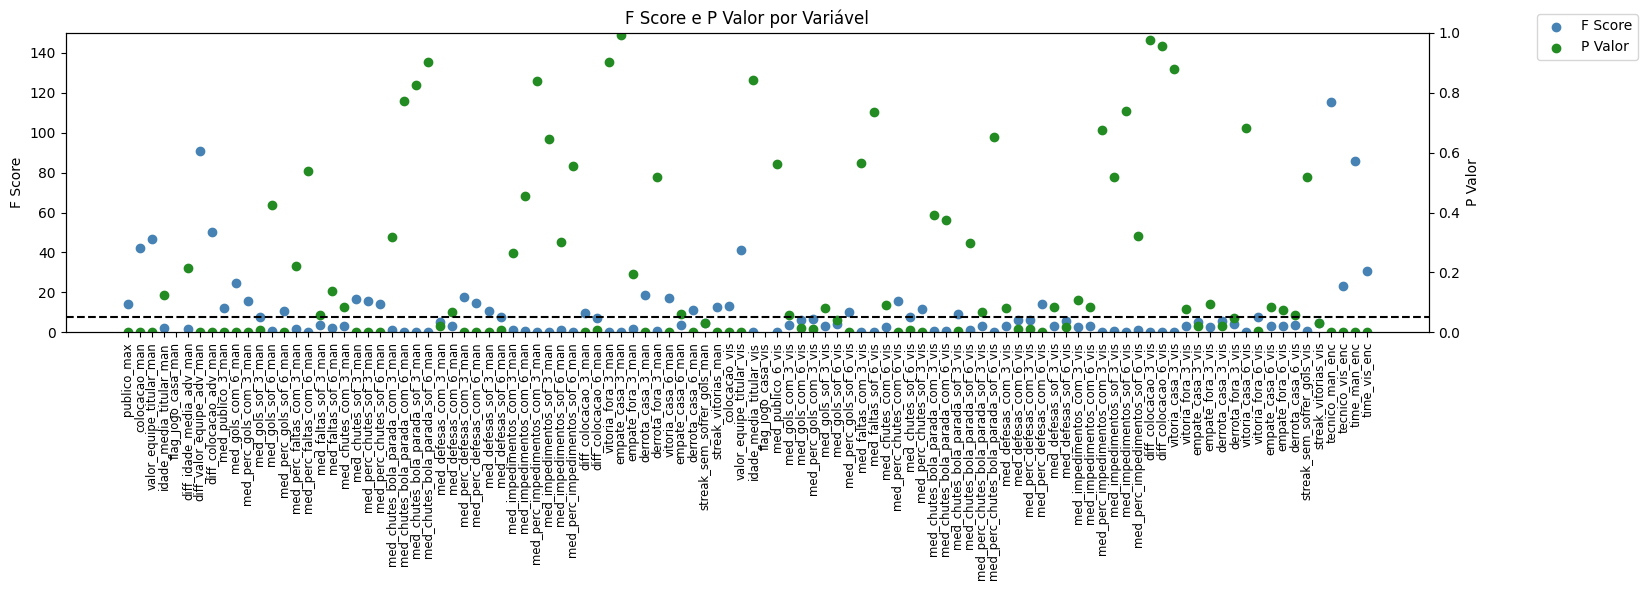

---- Variáveis em Ordem Descrescente de Força ----
tecnico_man_enc
diff_valor_equipe_adv_man
time_man_enc
diff_colocacao_adv_man
valor_equipe_titular_man
colocacao_man
valor_equipe_titular_vis
time_vis_enc
med_gols_com_6_man
tecnico_vis_enc
derrota_casa_3_man
med_perc_defesas_com_3_man
vitoria_casa_6_man
med_chutes_sof_3_man
med_perc_gols_com_3_man
med_perc_chutes_com_6_vis
med_perc_chutes_sof_3_man
med_perc_defesas_com_6_man
med_perc_defesas_com_6_vis
med_perc_chutes_sof_6_man
publico_max
colocacao_vis
streak_vitorias_man
med_publico_3_man
med_perc_chutes_sof_3_vis
derrota_casa_6_man
med_defesas_sof_3_man
med_perc_gols_sof_6_man
med_perc_gols_sof_6_vis
diff_colocacao_3_man
med_chutes_bola_parada_sof_3_vis
vitoria_fora_6_vis
med_defesas_sof_6_man
med_chutes_sof_6_vis
med_gols_sof_3_man
diff_colocacao_6_man
med_perc_gols_com_3_vis
med_perc_defesas_com_3_vis
med_defesas_com_6_vis
med_gols_com_6_vis
med_defesas_sof_6_vis
derrota_casa_3_vis
empate_casa_3_vis
med_defesas_com_3_man
streak_se

In [298]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(15, 6))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.set_ylim(0,150)
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.10, 0.98))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

C:\Users\matcg\AppData\Local\Temp\ipykernel_17332\4014154707.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')


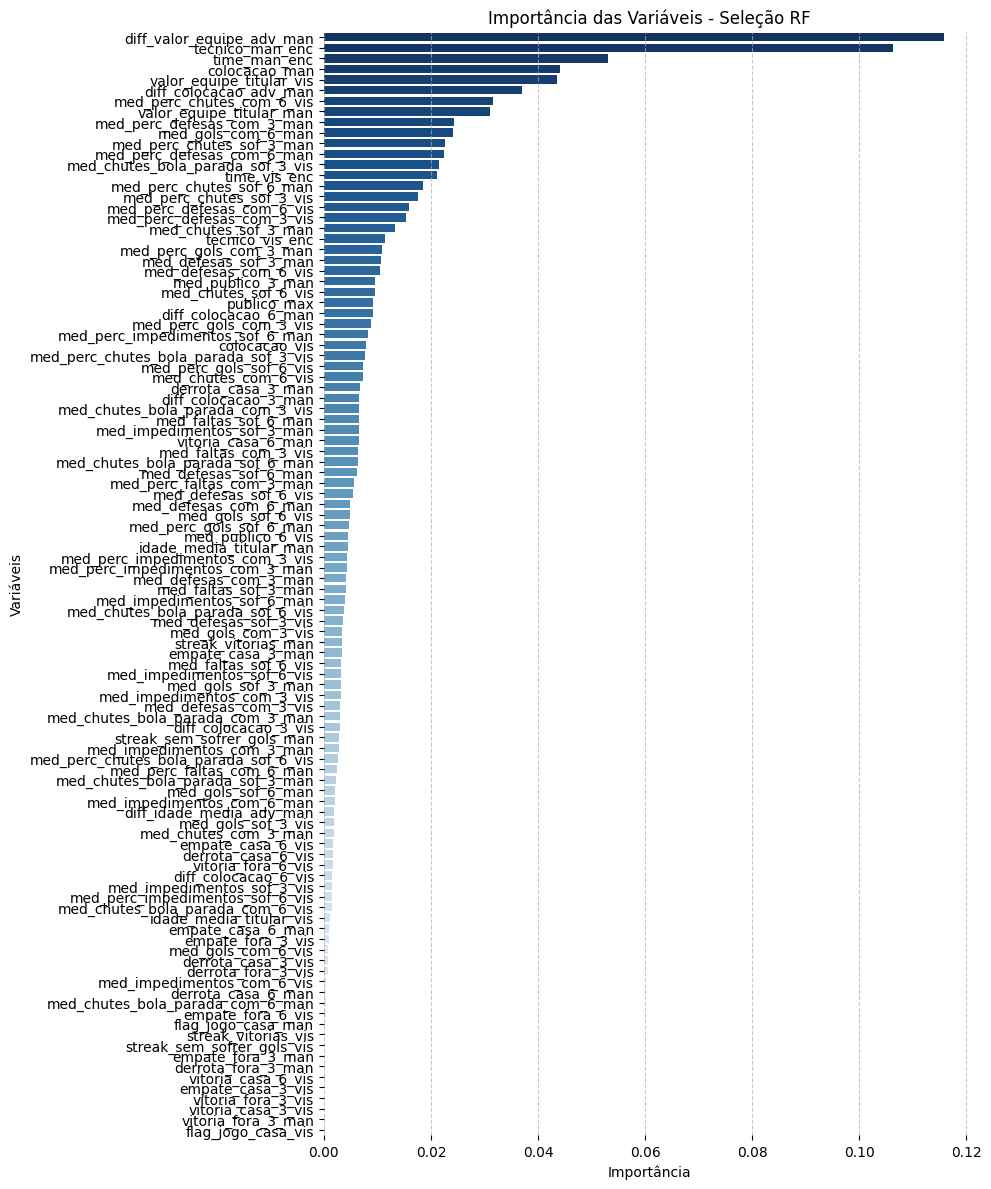

In [299]:
# Crie um modelo de RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Treine o modelo
rf_model.fit(df_filter, y_train)

# Obtenha a importância das características
feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 12 variáveis (med_perc_defesas_com_3 pra cima). Assim, podemos adotar um corte na importancia de 0.03

In [300]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.02, 'RF_SEL'] = 1

In [301]:
feature_importances[feature_importances['RF_SEL']==1]

,VAR,IMP,RF_SEL
1,colocacao_man,0.044106,1
2,valor_equipe_titular_man,0.030936,1
6,diff_valor_equipe_adv_man,0.115845,1
7,diff_colocacao_adv_man,0.037080,1
9,med_gols_com_6_man,0.024082,1
20,med_perc_chutes_sof_3_man,0.022635,1
28,med_perc_defesas_com_3_man,0.024224,1
29,med_perc_defesas_com_6_man,0.022430,1
51,valor_equipe_titular_vis,0.043614,1
64,med_perc_chutes_com_6_vis,0.031604,1


Agora, vamos observar como se comporta a precisão de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

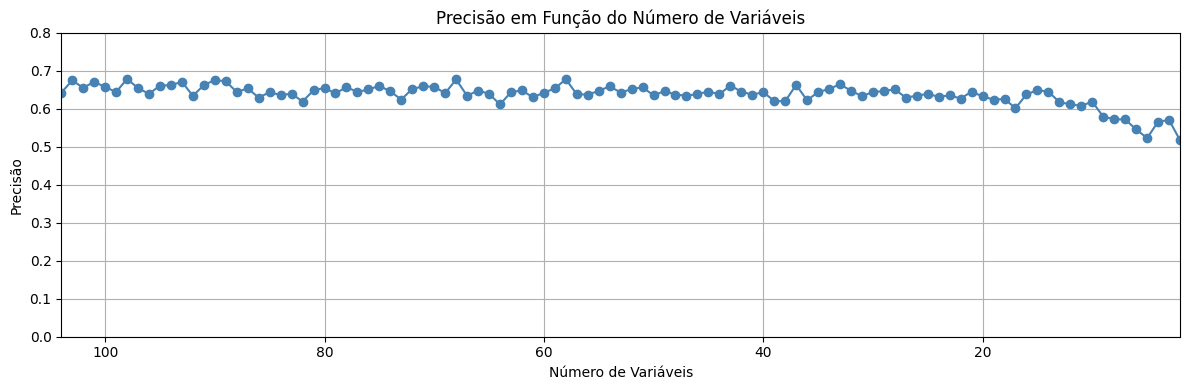

In [302]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
precision_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)    
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    
    precision = precision_score(y_test, y_pred)
    num_features_list.append(i)
    precision_list.append(precision)

plt.figure(figsize=(12, 4))
plt.plot(num_features_list, precision_list, marker='o', linestyle='-', color='steelblue')
plt.xlabel('Número de Variáveis')
plt.ylabel('Precisão')
plt.title('Precisão em Função do Número de Variáveis')
plt.grid(True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

Nota-se que a partir de 15 variáveis a precisão do Modelo Baseline começa a perder força.

In [303]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')

In [304]:
df_compara_sel

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
0,publico_max,14.097371,1.817359e-04,1,0.009177,0
1,colocacao_man,42.239374,1.172706e-10,1,0.044106,1
2,valor_equipe_titular_man,46.704602,1.298375e-11,1,0.030936,1
3,idade_media_titular_man,2.377400,1.233608e-01,0,0.004416,0
4,flag_jogo_casa_man,NaN,NaN,0,0.000000,0
...,...,...,...,...,...,...
99,streak_vitorias_vis,4.596601,3.223193e-02,1,0.000000,0
100,tecnico_man_enc,115.260309,9.283641e-26,1,0.106323,1
101,tecnico_vis_enc,23.091486,1.736032e-06,1,0.011398,0
102,time_man_enc,85.565436,9.678905e-20,1,0.053055,1


In [305]:
vars_sel = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas 12 que foram selecionadas por RandomForest

In [306]:
vars_sel

['colocacao_man',
 'valor_equipe_titular_man',
 'diff_valor_equipe_adv_man',
 'diff_colocacao_adv_man',
 'med_gols_com_6_man',
 'med_perc_chutes_sof_3_man',
 'med_perc_defesas_com_3_man',
 'med_perc_defesas_com_6_man',
 'valor_equipe_titular_vis',
 'med_perc_chutes_com_6_vis',
 'med_chutes_bola_parada_sof_3_vis',
 'tecnico_man_enc',
 'time_man_enc',
 'time_vis_enc']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

OBS: As variáveis time_enc e time_adversario_enc foram retiradas de forma a evitar overfitting ou ocasionar um viés em relação ao time vs. time adversário. Assim, manteremos apenas o tecnico como variável encoded.

In [307]:
vars_final = [
'colocacao_man',
 'valor_equipe_titular_man',
 'diff_valor_equipe_adv_man',
 'diff_colocacao_adv_man',
 'med_gols_com_6_man',
 'med_perc_chutes_sof_3_man',
 'med_perc_defesas_com_3_man',
#  'med_perc_defesas_com_6_man',
 'valor_equipe_titular_vis',
#  'med_perc_chutes_com_6_vis',
 'med_chutes_bola_parada_sof_3_vis',
#  'tecnico_man_enc',
#  'time_man_enc',
#  'time_vis_enc'
]

num_finais = [
'colocacao_man',
'valor_equipe_titular_man',
'diff_valor_equipe_adv_man',
'diff_colocacao_adv_man',
'med_gols_com_6_man',
'med_perc_chutes_sof_3_man',
'med_perc_defesas_com_3_man',
'valor_equipe_titular_vis',
'med_chutes_bola_parada_sof_3_vis'
 ]

# cat_ord_finais = ['tecnico_enc', 
#                   'time_enc', 
#                   'time_adversario_enc'
#                   ]
cat_ord_finais = []


preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização. Podemos escolher a precisão, que mede a proporção de todas as previsões corretas que o modelo fez. Além disso, podemos utilizar uma abordagem de retorno para apostas através da métrica ROI (Return Over Investment)

Sendo assim, vamos combinar a precisão e o ROI na nossa métrica de maximização, adotando pesos para ambos.
Em resumo:

-   O ROI mede a lucratividade financeira, indicando diretamente a capacidade do modelo de gerar retornos sobre o investimento.
-   A precisão é ideal para evitar falsos positivos. Com isso, evitariamos perdas financeiras ao apostar na vitoria de um determinado jogo.

Para cada jogo vamos considerar que será apostado $10 e que para cada ganho, tenha um lucro de 10% sobre o valor apostado

In [308]:
def roi_score(y_true, y_pred_proba, stake_per_bet=10):
    '''
    Calcula o retorno sobre o investimento (ROI)
    '''   

    y_pred = (y_pred_proba >= 0.5).astype(int) # Limiar de 0.5

    total_bets = len(y_true)
    total_wins = sum(y_true * y_pred)

    total_payouts = total_wins * stake_per_bet * 1.1  # Considerando 10% de lucro em vitorias
    total_staked = total_bets * stake_per_bet # Total apostado nao considerando lucros
    net_profit = total_payouts - total_staked
    
    return (net_profit / total_staked)

In [309]:
def cost_sensitive_precision(y_true, y_pred, tp_weight=1, fp_weight=5):
    '''
    Calcula a Precisao com pesos aplicados no TP e FP de 
    forma a penalizar falsos positivos.

    Este método é util quando temos classes desbalanceada. No nosso caso, a taxa de vitoria é 30%
    '''    

    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]  
    fp = cm[0, 1] 

    weighted_tp = -tp_weight*tp
    weighted_fp = -fp_weight*fp    

    cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)

    if np.isnan(cost_sensitive_precision):
        return 0
    else:
        return cost_sensitive_precision

In [310]:
def evaluate_calibration(y_true, y_prob, n_bins=5):
    """
    Calculates calibration metrics.

    Args:
        y_true (array-like): True binary outcomes (0 or 1).
        y_prob (array-like): Predicted probabilities of positive class.
        n_bins (int, optional): Number of bins for calibration curve. Defaults to 5.

        Expected Calibration Error (ECE)
    """

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

        # Calculate ECE
    ece = np.abs(prob_true - prob_pred).mean()

    return ece

In [311]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [118]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=400, test_size=350)

# metrics_folds = []    
for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

    tam_treino = len(train_index)
    tam_teste = len(test_index)
    total = tam_treino + tam_teste
    print(f'TREINO: {tam_treino}, TESTE: {tam_teste}, SOMA: {total}')
    print(f'TREINO: {train_index}, TESTE: {test_index}')

TREINO: 176, TESTE: 350, SOMA: 526
TREINO: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175], TESTE: [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 23

In [164]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
            max_iter=trial.suggest_int('max_iter', 100, 1000),
            tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )

    # tscv = TimeSeriesSplit(n_splits=5)
    
    # tscv = TimeSeriesSplit(n_splits=4, max_train_size=800, test_size=300)

    # metrics_folds = []    
    # for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

    #     train = df_train_f.iloc[train_index]
    #     X_train = train.drop(['vitoria'],axis=1)
    #     y_train = train['vitoria']
    #     valid = df_train_f.iloc[test_index]
    #     X_valid = valid.drop(['vitoria'],axis=1)
    #     y_valid = valid['vitoria']

    #     model.fit(X_train, y_train)

    #     pred = model.predict(X_valid)
    #     y_pred_proba = model.predict_proba(X_valid)[:, 1]        
    #     # w_precision = cost_sensitive_precision(y_valid, pred)
    #     # ece = evaluate_calibration(y_valid, y_pred_proba, 10)
    #     # roi = roi_score(y_valid, y_pred_proba)        
    #     # result = 0.8 * w_precision + 0.2 * roi
    #     # result = roc_auc_score(y_valid, y_pred_proba)
    #     result = log_loss(y_valid, y_pred_proba)

    #     metrics_folds.append(result)
               
    # return np.mean(metrics_folds)   
    
    train = df_train_f.iloc[:861] # 70%
    X_train = train.drop(['vitoria'],axis=1)
    y_train = train['vitoria']
    valid = df_train_f.iloc[861:] # 30%
    X_valid = valid.drop(['vitoria'],axis=1)
    y_valid = valid['vitoria']

    model.fit(X_train, y_train)

    # pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]        
    # w_precision = cost_sensitive_precision(y_valid, pred)
    # ece = evaluate_calibration(y_valid, y_pred_proba)
    # roi = roi_score(y_valid, y_pred_proba)        
    # result = 0.8 * w_precision + 0.2 * roi
    # result = 0.8 * (1 - ece) + 0.2 * roi
    result = log_loss(y_valid, y_pred_proba)
    # result = roc_auc_score(y_valid, y_pred_proba)

    return result


models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

    best_params = study.best_params
    best_value = round(study.best_value,4)

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

[I 2024-01-15 20:51:30,632] A new study created in memory with name: no-name-700e345b-32be-4cab-9fce-29bf1fc63428


------ RandomForest ------


[I 2024-01-15 20:51:32,655] Trial 0 finished with value: 0.609875203472599 and parameters: {'n_estimators': 406, 'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 48, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 0 with value: 0.609875203472599.
[I 2024-01-15 20:51:34,886] Trial 1 finished with value: 0.6183456924097185 and parameters: {'n_estimators': 621, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 250, 'min_samples_leaf': 22, 'bootstrap': False}. Best is trial 1 with value: 0.6183456924097185.
[I 2024-01-15 20:51:35,806] Trial 2 finished with value: 0.6177428106348344 and parameters: {'n_estimators': 339, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 184, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 1 with value: 0.6183456924097185.
[I 2024-01-15 20:51:37,607] Trial 3 finished with value: 0.6247362392234882 and parameters: {'n_estimators': 483, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 179, 'min_sampl

------ LogisticRegression ------


[I 2024-01-15 20:52:52,957] Trial 5 finished with value: 0.6461988304093568 and parameters: {'C': 70.85721663941601, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 209, 'tol': 0.0009780337016659412}. Best is trial 5 with value: 0.6461988304093568.
[I 2024-01-15 20:52:52,973] Trial 6 finished with value: 0.5 and parameters: {'C': 0.001608166928363465, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 568, 'tol': 0.0012399967836846098}. Best is trial 5 with value: 0.6461988304093568.
[I 2024-01-15 20:52:52,985] Trial 7 finished with value: 0.5 and parameters: {'C': 0.012856617791467934, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 638, 'tol': 0.0069782812651260325}. Best is trial 5 with value: 0.6461988304093568.
[I 2024-01-15 20:52:53,002] Trial 8 finished with value: 0.5 and parameters: {'C': 0.003395900933162751, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 344, 'tol': 0.004544383960336014}. Best is trial 5 with value: 0.6461988304093568.
[I 2024-01-15 20:52:53,021] Tr

------ LGBM ------


[I 2024-01-15 20:52:57,928] Trial 0 finished with value: 0.5454271417375053 and parameters: {'n_estimators': 406, 'max_depth': 8, 'learning_rate': 0.0483437145318464, 'num_leaves': 94, 'min_data_in_leaf': 39, 'bagging_fraction': 0.16443457513284063, 'reg_alpha': 0.0014936568554617625, 'reg_lambda': 0.39676050770529875}. Best is trial 0 with value: 0.5454271417375053.
[I 2024-01-15 20:52:58,050] Trial 1 finished with value: 0.6140652318080424 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.0011152328125494347, 'num_leaves': 146, 'min_data_in_leaf': 168, 'bagging_fraction': 0.2202157195714934, 'reg_alpha': 0.0035113563139704067, 'reg_lambda': 0.0035498788321965025}. Best is trial 1 with value: 0.6140652318080424.
[I 2024-01-15 20:52:58,143] Trial 2 finished with value: 0.6320913968770724 and parameters: {'n_estimators': 339, 'max_depth': 5, 'learning_rate': 0.009860942908083906, 'num_leaves': 51, 'min_data_in_leaf': 126, 'bagging_fraction': 0.14809892204552141, '

------ NaiveBayes ------


[I 2024-01-15 20:53:21,095] Trial 11 finished with value: 0.6454150841020077 and parameters: {'var_smoothing': 8.914401041476794e-08}. Best is trial 0 with value: 0.6454150841020077.
[I 2024-01-15 20:53:21,126] Trial 12 finished with value: 0.6454150841020077 and parameters: {'var_smoothing': 7.041830285016006e-05}. Best is trial 0 with value: 0.6454150841020077.
[I 2024-01-15 20:53:21,151] Trial 13 finished with value: 0.6454150841020077 and parameters: {'var_smoothing': 5.423185466354634e-08}. Best is trial 0 with value: 0.6454150841020077.
[I 2024-01-15 20:53:21,160] Trial 14 finished with value: 0.6454150841020077 and parameters: {'var_smoothing': 3.0499733967435514e-07}. Best is trial 0 with value: 0.6454150841020077.
[I 2024-01-15 20:53:21,179] Trial 15 finished with value: 0.6454150841020077 and parameters: {'var_smoothing': 1.994322948311829e-05}. Best is trial 0 with value: 0.6454150841020077.
[I 2024-01-15 20:53:21,211] Trial 16 finished with value: 0.6454150841020077 and par

------ AdaBoostClassifier ------


[I 2024-01-15 20:53:25,278] Trial 0 finished with value: 0.5778320371375174 and parameters: {'n_estimators': 406, 'learning_rate': 0.36808608148776095}. Best is trial 0 with value: 0.5778320371375174.
[I 2024-01-15 20:53:29,248] Trial 1 finished with value: 0.6089558087659009 and parameters: {'n_estimators': 746, 'learning_rate': 0.04128205343826222}. Best is trial 1 with value: 0.6089558087659009.
[I 2024-01-15 20:53:30,215] Trial 2 finished with value: 0.5913968770724061 and parameters: {'n_estimators': 198, 'learning_rate': 0.0026364803038431655}. Best is trial 1 with value: 0.6089558087659009.
[I 2024-01-15 20:53:30,766] Trial 3 finished with value: 0.599776933743293 and parameters: {'n_estimators': 105, 'learning_rate': 0.21766241123453672}. Best is trial 1 with value: 0.6089558087659009.
[I 2024-01-15 20:53:33,652] Trial 4 finished with value: 0.601314282269247 and parameters: {'n_estimators': 621, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: 0.6089558087659

------ KNN ------


[I 2024-01-15 20:58:20,929] Trial 8 finished with value: 0.5808163019231929 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.6304485440405136.
[I 2024-01-15 20:58:20,964] Trial 9 finished with value: 0.6043286911436667 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.6304485440405136.
[I 2024-01-15 20:58:21,027] Trial 10 finished with value: 0.62223427985772 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.6304485440405136.
[I 2024-01-15 20:58:21,063] Trial 11 finished with value: 0.627901368541629 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.6304485440405136.
[I 2024-01-15 20:58:21,108] Trial 12 finished with value: 0.62223427985772 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.6304485440405136.
[I 2024-01-15 20:58:21,144] Trial 13 finished w

------ SVC ------


[I 2024-01-15 20:58:25,602] Trial 1 finished with value: 0.622701513233255 and parameters: {'C': 0.008632008168602538, 'kernel': 'linear', 'gamma': 0.008629132190071854, 'shrinking': False, 'probability': True}. Best is trial 0 with value: 0.6304636160848858.
[I 2024-01-15 20:58:25,749] Trial 2 finished with value: 0.6381805028034002 and parameters: {'C': 4.0428727350273315, 'kernel': 'linear', 'gamma': 17.71884735480682, 'shrinking': False, 'probability': True}. Best is trial 2 with value: 0.6381805028034002.
[I 2024-01-15 20:58:26,345] Trial 3 finished with value: 0.6386175920901912 and parameters: {'C': 98.77700294007911, 'kernel': 'linear', 'gamma': 0.018794668241638456, 'shrinking': False, 'probability': True}. Best is trial 3 with value: 0.6386175920901912.
[I 2024-01-15 20:58:26,460] Trial 4 finished with value: 0.6244347983360463 and parameters: {'C': 0.06690421166498801, 'kernel': 'linear', 'gamma': 1.40779231399724, 'shrinking': True, 'probability': True}. Best is trial 3 wit

------ DecisionTree ------


[I 2024-01-15 21:00:03,441] Trial 6 finished with value: 0.5867245433170556 and parameters: {'max_depth': 4, 'min_samples_split': 21, 'max_leaf_nodes': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6028064146620848.
[I 2024-01-15 21:00:03,488] Trial 7 finished with value: 0.593054801953337 and parameters: {'max_depth': 5, 'min_samples_split': 34, 'max_leaf_nodes': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.6028064146620848.
[I 2024-01-15 21:00:03,508] Trial 8 finished with value: 0.580213420148309 and parameters: {'max_depth': 1, 'min_samples_split': 52, 'max_leaf_nodes': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.6028064146620848.
[I 2024-01-15 21:00:03,558] Trial 9 finished with value: 0.5817959848073793 and parameters: {'max_depth': 4, 'min_samples_split': 34, 'max_leaf_nodes': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.6028064146620848.
[I 2024-01-15 21:00:03,649] Trial 10 finished with value: 0.5321637426900585 and parameters: {'max

In [165]:
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
1,LogisticRegression,"{'C': 145.76956201941084, 'penalty': 'l1', 'so...",0.6465
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},0.6454
6,SVC,"{'C': 66.12693423585846, 'kernel': 'linear', '...",0.6387
2,LGBM,"{'n_estimators': 763, 'max_depth': 2, 'learnin...",0.6356
0,RandomForest,"{'n_estimators': 99, 'max_depth': 5, 'criterio...",0.6331
4,AdaBoostClassifier,"{'n_estimators': 618, 'learning_rate': 0.00930...",0.6316
5,KNN,"{'n_neighbors': 13, 'weights': 'uniform', 'p': 2}",0.6304
7,DecisionTree,"{'max_depth': 3, 'min_samples_split': 62, 'max...",0.6114


In [167]:
# Com walk forward
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.016595183361157326, 'penalty': 'l2', '...",0.20
6,SVC,"{'C': 0.5450293694558254, 'kernel': 'linear', ...",0.19
0,RandomForest,"{'n_estimators': 141, 'max_depth': 5, 'criteri...",0.03
2,LGBM,"{'n_estimators': 61, 'max_depth': 7, 'learning...",0.03
4,AdaBoostClassifier,"{'n_estimators': 137, 'learning_rate': 0.01828...",0.01
5,KNN,"{'n_neighbors': 4, 'weights': 'uniform', 'p': 1}",0.00
3,NaiveBayes,{'var_smoothing': 7.041830285016006e-05},-0.01
7,DecisionTree,"{'max_depth': 3, 'min_samples_split': 59, 'max...",-0.03


In [214]:
# Dados fixos
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
6,SVC,"{'C': 0.24751990713351774, 'kernel': 'linear',...",0.62
1,LogisticRegression,"{'C': 0.012095489763207533, 'penalty': 'l2', '...",0.60
0,RandomForest,"{'n_estimators': 476, 'max_depth': 2, 'criteri...",0.08
4,AdaBoostClassifier,"{'n_estimators': 425, 'learning_rate': 0.00374...",0.08
2,LGBM,"{'n_estimators': 271, 'max_depth': 7, 'learnin...",0.07
5,KNN,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 1}",0.02
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},-0.00
7,DecisionTree,"{'max_depth': 5, 'min_samples_split': 34, 'max...",0.00


In [134]:
# Com ECE
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.840890658104122, 'penalty': 'l2', 'sol...",0.6583
6,SVC,"{'C': 957.6921590383761, 'kernel': 'linear', '...",0.6603
2,LGBM,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.6627
0,RandomForest,"{'n_estimators': 275, 'max_depth': 3, 'criteri...",0.6645
5,KNN,"{'n_neighbors': 19, 'weights': 'uniform', 'p': 2}",0.6751
4,AdaBoostClassifier,"{'n_estimators': 135, 'learning_rate': 0.01789...",0.6772
7,DecisionTree,"{'max_depth': 1, 'min_samples_split': 10, 'max...",0.6849
3,NaiveBayes,{'var_smoothing': 9.964550094689261e-05},0.9398


In [166]:
comparison_df.iloc[1]['best_params']

{'C': 145.76956201941084,
 'penalty': 'l1',
 'solver': 'liblinear',
 'max_iter': 844,
 'tol': 0.002377384436383541}

In [170]:
# AUC
comparison_df.iloc[1]['best_params']

{'C': 1.9315595788530047,
 'penalty': 'l2',
 'solver': 'liblinear',
 'max_iter': 353,
 'tol': 0.0005047116346834324}

In [87]:
comparison_df.iloc[2]['best_params']


{'n_estimators': 134,
 'max_depth': 2,
 'learning_rate': 0.0012707770074499693,
 'num_leaves': 55,
 'min_data_in_leaf': 84,
 'bagging_fraction': 0.27863554145615693,
 'reg_alpha': 0.3063462210622082,
 'reg_lambda': 0.011756010900231853}

O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi a Regressão Logistica. Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [312]:
# Com LOG LOSS
model_f = LogisticRegression(C=0.840890658104122,
              penalty='l2',
              solver='liblinear',
              max_iter=836,
              tol= 0.00029110832195342284,
              random_state=42)

# Com AUC SCORE
# model_f = LogisticRegression(C=145.76956201941084,
#               penalty='l1',
#               solver='liblinear',
#               max_iter=844,
#               tol= 0.002377384436383541,
#               random_state=42)


model_f.fit(X_train_f, y_train)
pred_train = model_f.predict(X_train_f)
pred_proba_train = model_f.predict_proba(X_train_f)[:,1]
pred_f = model_f.predict(X_test_f)
pred_proba_test = model_f.predict_proba(X_test_f)[:,1]

print('--- TREINO ---')
print(f'ROI: {roi_score(y_train, pred_train)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_train, pred_train)}')
print(f'Precisao: {precision_score(y_train, pred_train)}')
print(f'ROC: {roc_auc_score(y_train, pred_proba_train)}')

print('--- TESTE ---')
print(f'ROI: {roi_score(y_test, pred_f)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_test, pred_f)}')
print(f'Precisao: {precision_score(y_test, pred_f)}')
print(f'ROC: {roc_auc_score(y_test, pred_proba_test)}')

--- TREINO ---
ROI: -0.7451876019575856
Precisao Penalizada: 0.23490488006617039
Precisao: 0.605543710021322
ROC: 0.6696080008580008
--- TESTE ---
ROI: -0.7276190476190476
Precisao Penalizada: 0.26
Precisao: 0.6372549019607843
ROC: 0.6848542274052479


In [ ]:
# --- TREINO ---
# ROI: -0.7451876019575856
# Precisao Penalizada: 0.23490488006617039
# Precisao: 0.605543710021322
# ROC: 0.6696080008580008
# --- TESTE ---
# ROI: -0.7276190476190476
# Precisao Penalizada: 0.26
# Precisao: 0.6372549019607843
# ROC: 0.6848542274052479

In [ ]:
# AUC
# --- TREINO ---
# ROI: -0.8853107344632768
# Precisao Penalizada: 0.22989807474518686
# Precisao: 0.5988200589970502
# --- TESTE ---
# ROI: -0.8853892215568863
# Precisao Penalizada: 0.29292929292929293
# Precisao: 0.6744186046511628

In [313]:
df_test_f = pd.concat([X_test_f, y_test], axis=1)
df_test_f['pred_vitoria'] = model_f.predict_proba(X_test_f)[:, 1] 

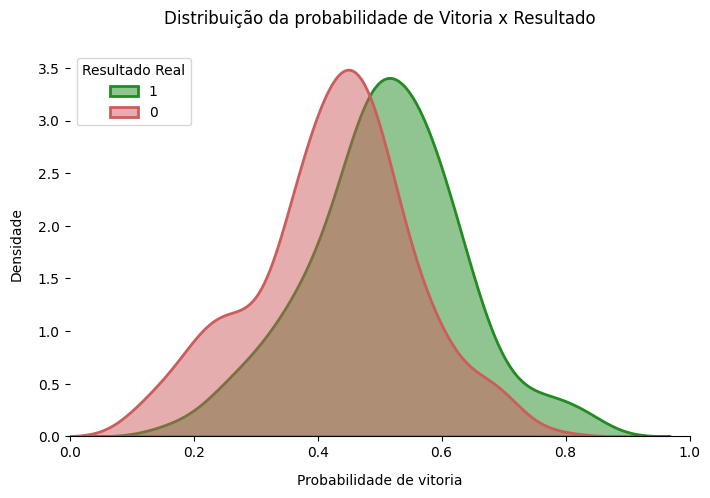

pred_vitoria                                                    \
               count      mean       std       min       25%       50%   
vitoria                                                                  
0              280.0  0.425653  0.127786  0.110560  0.356592  0.434137   
1              245.0  0.509004  0.124220  0.153937  0.439284  0.511576   

                             
              75%       max  
vitoria                      
0        0.501359  0.779413  
1        0.584819  0.844985

In [314]:
plt.figure(figsize=(8,5))

sns.kdeplot(df_test_f, 
            x='pred_vitoria', 
            hue='vitoria', 
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','forestgreen']
            )

plt.xlabel('Probabilidade de vitoria', labelpad=10)
plt.ylabel('Densidade', labelpad=10)
plt.title('Distribuição da probabilidade de Vitoria x Resultado', fontsize=12, pad=20)
plt.legend(title='Resultado Real', title_fontsize=10, labels=['1','0'], loc='upper left')

plt.xlim(0, 1)
sns.despine(left=True)
plt.show()

df_test_f.groupby('vitoria')[['pred_vitoria']].describe()

In [319]:
df_test_f['AvgH'] = df_test['AvgH']
df_test_f['AvgA'] = df_test['AvgA']

preds_prob = df_test_f['pred_vitoria'].values
y_true = df_test_f['vitoria'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values

In [320]:
def kelly_criterion_fraction(probability, odds, fraction=1.0):
    """
    Calculate the Kelly Criterion fraction for optimal bet sizing.

    Parameters:
    - odds: Decimal odds (e.g., 2.0 for even money, 3.0 for 2:1 odds, etc.).
    - probability: Probability of winning (should be between 0 and 1).
    - fraction: Fraction of the current bankroll to consider (default is 1.0).

    Returns:
    - The fraction of the current bankroll to bet according to the Kelly Criterion.
    """
    b = odds - 1  # Net odds received on the bet
    q = 1 - probability
    kelly = (b * probability - q) / b

    # Ensure the fraction is within the specified limits
    kelly_fraction = fraction*kelly

    return kelly_fraction

[163.45461538324437, 0, 0, 189.36903049049616, 37.69878702891537, 0, 0, 0, 0, 0, 0, 0, 0, 0, 125.20416718260944, 0, 0, 391.34102510315375, 454.6410256601863, 116.86573285453682, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182.72556106377704, 0, 889.1676372677508, 882.8852871459317, 0, 0, 0, 493.28798877640577, 154.73635306124098, 0, 66.6184605500373, 0, 72.96408567385231, 18.475915468031214, 0, 0, 0, 0, 0, 0, 0, 0, 321.67377036479655, 0, 0, 0, 0, 0, 0, 96.47043923725268, 0, 0, 255.5467349453312, 135.19108669958658, 0, 0, 0, 0, 412.6861014430554, 0, 811.3782339609631, 0, 303.42443692267915, 607.2958640680143, 0, 217.66802897326394, 453.3809912553274, 0, 0, 148.8672810512513, 0, 0, 935.0494679656658, 0, 0, 0, 0, 0, 0, 0, 730.0674412096671, 0, 305.85938039693764, 0, 0, 0, 683.6058704152539, 270.01804916885584, 0, 456.1743309067072, 0, 0, 0, 0, 0, 0, 14.221922362581907, 0, 0, 0, 0, 216.17453113275704, 0, 422.1855771159475, 0, 0, 0, 0, 0, 0, 0, 1024.294226205687, 61.40336046388936, 0, 687.0679870996698, 

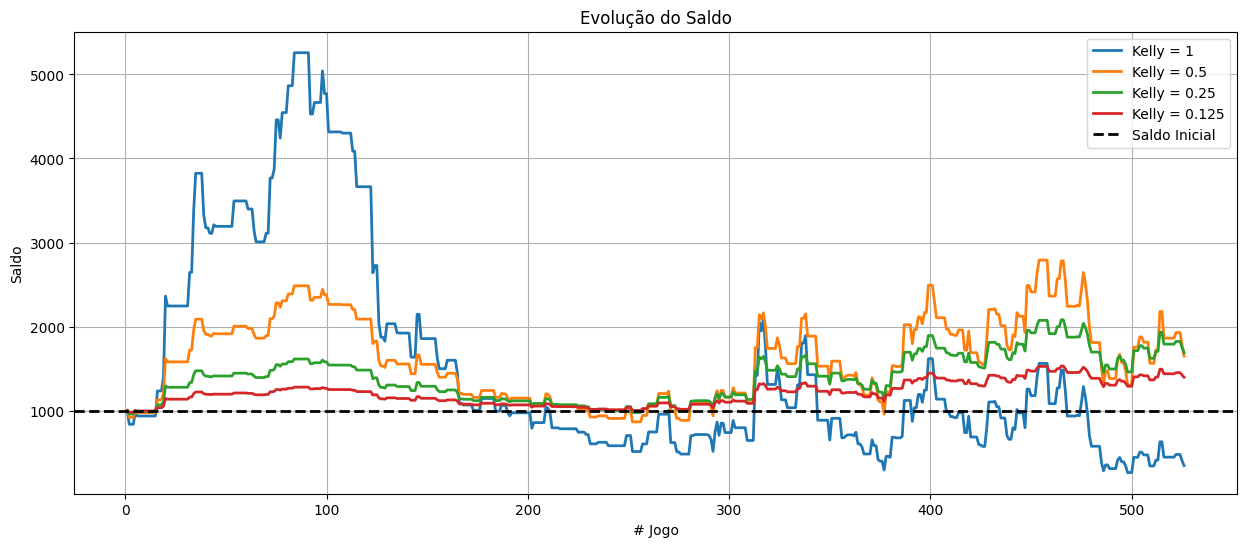

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,34380.94,38.21,41.79,1.000,343.87,-65.61
1,22567.73,38.21,41.79,0.500,1648.07,64.81
2,9943.33,38.21,41.79,0.250,1687.57,68.76
3,4261.63,38.21,41.79,0.125,1396.27,39.63


In [325]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
# odds = 1.8
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros = [], [], []    
    for prob, odds, outcome in zip(preds_prob, odds_homewin, y_true):
        
        f_star = kelly_criterion_fraction(prob, odds, k)       
        stake = f_star*bankroll

        if stake < 0:
            stake = 0

        if outcome == 1:
            # winning = 1
            win_value = stake * (odds - 1)
            lucros.append(win_value)
            bankroll += win_value
        else:
            # winning = 0
            bankroll -= stake
            lucros.append(-stake)
        
        aposta_ganha = (1 if stake*outcome>0 else 0)
        
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(stakes)
    print(f'Lucro total: {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes) 
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({'total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
    })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

# Print results
# print(f"Bankroll final: {bankroll:.2f}")
# print(f"Bankroll history: {bankroll_history}")
# print(f"Total ROI: {roi:.2f} %")
# print(f"Total ROI 2 : {roi2:.2f} %")
# print(f"Bets: {stakes}")
# print(f"Winnings: {winnings}")

# Customize plot
plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k